- *Machine* is our machine object. It contains a game object, which makes interfacing with the game simple. Access to game information and communication is done in the following way:
    - The game score is **self.game.score**
    - The game matrix is **self.game.matrix**
    - Commanding the game is done thought the **self.act()** function. It should return:
        - **"'w'"** to go up
        - **"'a'"** to go left
        - **"'s'"** to go right
        - **"'d'"** to go down
    - The **self.run()** function is an infinite loop that calls for a decision from the machine and tells the game to execute it and update.

Using TensorFlow backend.


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


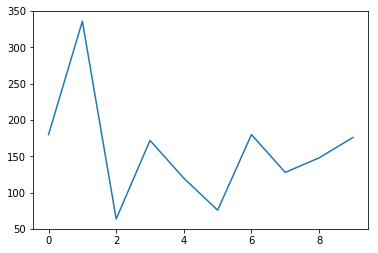

In [1]:
%matplotlib inline

import time
import puzzle
import csv
import matplotlib.pyplot as plt
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import RMSprop
import numpy as np
import random

MAX_EPISODES=10
INDEX_EPISODE=0
INDEX_EPOCH=1
INDEX_REWARD=2
INDEX_LOSS=3
INDEX_SCORE=4
INDEX_INCREMENT=5
INDEX_LOST=6
INDEX_LAST_STATE=7
INDEX_ACTION=8
INDEX_CURRENT_STATE=9
INDEX_WEIGHTS=10
LOG_LOCATION='../logs/log.csv'
LOG_ITERATION=100 # Logs after this many global iterations
#ACCESS SCORE AS self.game.score
#ACCESS MATRIX AS self.game.matrix
#DECIDE ACTION TO TAKE IN act()
#POSSIBLE ACTIONS:
#	go up:		"'w'"
#	go left:	"'a'"
#	go right:	"'s'"
#	go down:	"'d'"

class Machine:
    game=puzzle.GameGrid() # Game object
    epoch=0
    episode=0
    loss=0
    reward=0
    verbose_logging=False
    weight_logging=False
    action="'w'"
    model = Sequential()
    inputVector=np.zeros((1, 9))
    lastState=np.zeros((1, 9))
    Qvalues0=np.zeros((1,4))
    Qvalues1=np.zeros((1,4))
    acts = ["'w'","'s'","'d'","'a'"]
    gamma = 0.9    # Discount rate
    epsilon = 0.99  # Exploration rate
    iteration = 0
    log_iteration=0
    dump=False
    buffer=np.zeros((1,7))
    bufferShape=np.zeros((1,7))
    def __init__(self, verbose_logging_in=False,weight_logging_in=False):
        self.dump=False
        self.verbose_logging=verbose_logging_in
        self.weight_logging=weight_logging_in
        # Create model
        self.model.add(Dense(20, input_dim=9, activation='tanh')) # Adds the first layer with 16 inputs
        self.model.add(Dense(20, activation='tanh'))              # Adds Hidden layer with 20 nodes (Removed 'uniform')
        self.model.add(Dense(4, activation='linear'))             # Adds output layer with 20 nodes
        self.model.compile(loss='mse',optimizer=RMSprop(lr=0.01)) # Creates the model from all of the above
        # Initialise log
        with open('../logs/log.csv', 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            if self.verbose_logging and self.weight_logging:
                writer.writerow(["EPISODE","EPOCH","REWARD","LOSS","TOTAL SCORE","INCREMENT IN SCORE","LOST","LAST STATE","ACTION","CURRENT STATE","WEIGHTS"]) 
                self.bufferShape=np.zeros((1,11))
            elif self.verbose_logging:
                writer.writerow(["EPISODE","EPOCH","LAST STATE","ACTION","CURRENT STATE","REWARD","LOSS","TOTAL SCORE","INCREMENT IN SCORE","LOST"])
                self.bufferShape=np.zeros((1,10))
            else:
                writer.writerow(["EPISODE","EPOCH","REWARD","LOSS","TOTAL SCORE","INCREMENT IN SCORE","LOST"]) 
                self.bufferShape=np.zeros((1,7))
        self.buffer=self.bufferShape
        self.buffer=self.buffer.tolist()
    def run(self):
        # Transform game state to 1D array
        for i in range(3):
            self.inputVector[0][0+3*i:3+3*i]=self.game.matrix[i]
        self.epoch=self.epoch+1 # Increase epoch
        self.iteration=self.iteration+1 # Increase global iteration
        self.log_iteration=self.log_iteration+1
        self.log() # Log model
        self.game.increment=self.get_reward() # Update reward if game has been lost
        self.game.key_down(self.act()) # Select action and update weights
        self.lastState=self.inputVector # For logging
        # Game loop
        self.game.update_idletasks
        self.game.update()
        # pool emaG
    def act(self):
        if random.random() >= self.epsilon:  # Exploration
            #print(" Random Action ")
            self.action = self.acts[random.randint(0,3)]
            return self.action
        else: 
            # Predict Q values of current state
            self.Qvalues1[0]=self.gamma*self.model.predict(self.inputVector)+self.game.increment
            # Extract Q value of the state
            Q1=np.amax(self.Qvalues1)
            Q1_index=self.Qvalues1.argmax()
            #Construct target vector
            self.Qvalues1=self.Qvalues0
            self.Qvalues1[0][Q1_index]=Q1
            # Update weights with respect to last step's prediction of this step's Q values
            self.loss=self.model.train_on_batch(self.lastState, self.Qvalues1)
            # Make this step's Q values next step's past Q values
            #self.Qvalues0=self.Qvalues1
            self.Qvalues0=self.gamma*self.model.predict(self.inputVector)+self.game.increment
            # Select action with highest Q value
            self.action=self.acts[self.Qvalues0.argmax()] # Don't delete this variable, it's used when logging
            return self.action
    def log(self):
        # Log episode, epoch, reward, error, score, increment in score, lost, previous state, action, next state, weights 
        if self.weight_logging:
            for layer in self.model.layers:
                weights = layer.get_weights() # list of numpy arrays
        if self.weight_logging and self.verbose_logging:
            self.buffer.append([self.episode,self.epoch,self.reward,self.loss,self.game.score,self.game.increment,self.game.result,self.lastState,self.action,self.inputVector,weights])
        elif self.verbose_logging:
            self.buffer.append([self.episode,self.epoch,self.reward,self.loss,self.game.score,self.game.increment,self.game.result,self.lastState,self.action,self.inputVector])
        else:
            self.buffer.append([self.episode,self.epoch,self.reward,self.loss,self.game.score,self.game.increment,self.game.result])
        if (self.log_iteration == LOG_ITERATION) or self.dump:
            with open(LOG_LOCATION, 'a', newline='') as csvfile:
                self.buffer=self.buffer[1:] # Remove first line of zeros               
                writer = csv.writer(csvfile)
                for row in self.buffer:
                    writer.writerow(row)
                # Reset buffer
                self.buffer=self.bufferShape
                self.buffer=self.buffer.tolist()
                self.log_iteration=0
    def dump_logs(self):
        self.dump=True
        self.log()
    def plot(self):         
        with open(LOG_LOCATION,newline='') as csvfile:
            reader=csv.reader(csvfile)
            # Transform reader to array
            data=list(reader) 
            # Allocate arrays
            x=[]
            y=[]
            # Get rid of labels
            a=data.pop(0)
            for row in data:
                # Search for lost games
                if row[INDEX_LOST]=="True": # Needed because it's read as a string and not a bool
                    x.append(row[INDEX_EPISODE]) # Episode
                    y.append(row[INDEX_SCORE]) # Total score     
            # Plot results
            fig, ax = plt.subplots()
            ax.plot(x, y)
    def get_reward(self):
        l=0
        if self.game.result: # If the agent lost
            l = -2*self.game.increment-self.game.score
            # Reset game
            self.game.reset()
            self.epoch=0
            self.episode=self.episode+1
        self.reward=self.game.increment + l # Don't delete this variable, it's used for logging
        return (self.reward)
        
our_machine = Machine()
while our_machine.episode<MAX_EPISODES:
    our_machine.run()
our_machine.dump_logs()
our_machine.plot()
